In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
#pip install statsmodels pmdarima matplotlib pandas


In [2]:
# Charger les données prétraitées
df = pd.read_csv("../preprocessing/preprocessed_timeseries.csv", parse_dates=True, index_col=0)

# Assurez-vous que l'index est au format datetime
df.index = pd.to_datetime(df.index)

# Identifier les colonnes à prédire (toutes sauf la date)
target_columns = df.columns.tolist()

# Dictionnaire pour stocker les prédictions
forecast_results = {}


Training SARIMA model for beer...
Performing stepwise search to minimize aic


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation

 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=118.308, Time=4.65 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=144.601, Time=0.05 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=131.067, Time=0.78 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=121.316, Time=1.34 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=143.172, Time=0.04 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=116.805, Time=3.32 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=117.362, Time=1.53 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=118.794, Time=7.23 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=116.389, Time=2.35 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,1,0)[12] intercept   : AIC=117.870, Time=6.76 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,1,1)[12] intercept   : AIC=120.380, Time=7.15 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,1,0)[12] intercept   : AIC=120.810, Time=2.18 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,1,0)[12] intercept   : AIC=115.148, Time=2.08 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=117.177, Time=0.69 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=116.942, Time=3.64 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=117.368, Time=2.70 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=115.369, Time=2.45 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,1,1)[12] intercept   : AIC=119.062, Time=5.61 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=122.189, Time=1.75 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=113.235, Time=1.22 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=115.596, Time=0.41 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=114.997, Time=2.84 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=114.610, Time=2.61 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=113.536, Time=1.48 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=117.168, Time=4.03 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,1,0)[12] intercept   : AIC=115.161, Time=2.41 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(1,1,0)[12] intercept   : AIC=117.232, Time=2.10 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,1,0)[12]             : AIC=111.823, Time=0.53 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,1,0)[12]             : AIC=114.252, Time=0.28 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,1,0)[12]             : AIC=113.588, Time=1.54 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,1,1)[12]             : AIC=113.208, Time=1.16 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,1,1)[12]             : AIC=112.135, Time=0.59 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,1,1)[12]             : AIC=115.761, Time=2.00 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,0)[12]             : AIC=129.706, Time=0.37 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,1,0)[12]             : AIC=113.756, Time=1.11 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,1,0)[12]             : AIC=113.744, Time=0.62 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,1,0)[12]             : AIC=120.769, Time=0.64 sec


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(1,1,0)[12]             : AIC=115.822, Time=1.08 sec

Best model:  ARIMA(2,0,0)(1,1,0)[12]          
Total fit time: 83.359 seconds
Best SARIMA Order for beer: (2, 0, 0), Seasonal: (1, 1, 0, 12)
MSE for beer: 0.0666


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


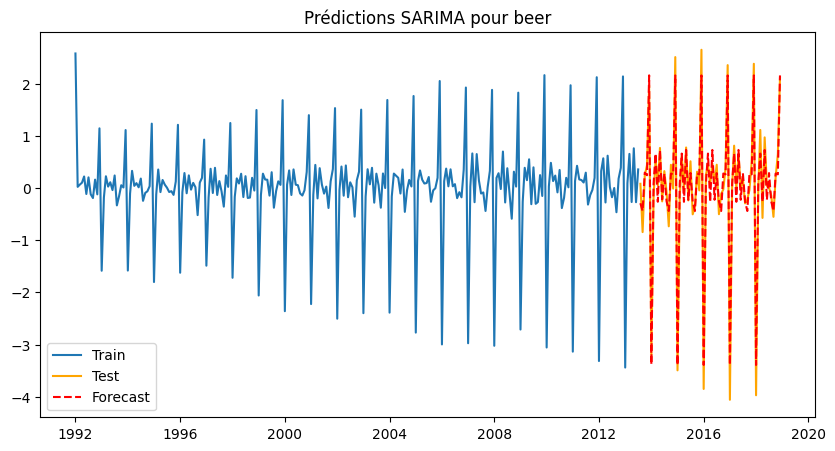

Toutes les prédictions SARIMA ont été enregistrées.


In [3]:
for column in target_columns:
    print(f"Training SARIMA model for {column}...")

    # Séparer train/test (80/20)
    split_index = int(len(df) * 0.8)
    train_df = df.iloc[:split_index][column]
    test_df = df.iloc[split_index:][column]

    # Trouver les meilleurs paramètres (p, d, q, P, D, Q, s) automatiquement
    auto_model = auto_arima(train_df, seasonal=True, m=12, stepwise=True, trace=True, suppress_warnings=True)
    best_order = auto_model.order  # (p, d, q)
    best_seasonal_order = auto_model.seasonal_order  # (P, D, Q, s)

    print(f"Best SARIMA Order for {column}: {best_order}, Seasonal: {best_seasonal_order}")

    # Entraîner le modèle SARIMA avec les paramètres trouvés
    model = SARIMAX(train_df, 
                    order=best_order, 
                    seasonal_order=best_seasonal_order,
                    enforce_stationarity=False, 
                    enforce_invertibility=False)
    
    sarima_model = model.fit(disp=False)

    # Faire des prédictions
    forecast = sarima_model.forecast(steps=len(test_df))

    # Calcul du Mean Squared Error (MSE)
    mse = mean_squared_error(test_df, forecast)
    print(f"MSE for {column}: {mse:.4f}")

    # Sauvegarder les résultats
    forecast_results[column] = pd.DataFrame({"ds": test_df.index, "yhat": forecast.values})

    # Visualisation
    plt.figure(figsize=(10, 5))
    plt.plot(train_df.index, train_df, label="Train")
    plt.plot(test_df.index, test_df, label="Test", color="orange")
    plt.plot(test_df.index, forecast, label="Forecast", linestyle="dashed", color="red")
    plt.title(f"Prédictions SARIMA pour {column}")
    plt.legend()
    plt.show()

# Sauvegarder les prévisions
for col, forecast in forecast_results.items():
    forecast.to_csv(f"forecast_sarima_{col}.csv", index=False)

print("Toutes les prédictions SARIMA ont été enregistrées.")
